In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import ndimage
import math
import keras
import re
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
dict_clean_img = {}
dict_img = {} 

In [3]:
import tensorflow as tf
import keras.backend.tensorflow_backend as tfback

In [4]:
def _get_available_gpus():
    """Get a list of available gpu devices (formatted as strings).

    # Returns
        A list of available GPU devices.
    """
    #global _LOCAL_DEVICES
    if tfback._LOCAL_DEVICES is None:
        devices = tf.config.list_logical_devices()
        tfback._LOCAL_DEVICES = [x.name for x in devices]
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

In [5]:
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

[]

In [6]:
from keras.models import model_from_json

In [7]:
model = keras.models.load_model('modem_trained.h5', compile=False)

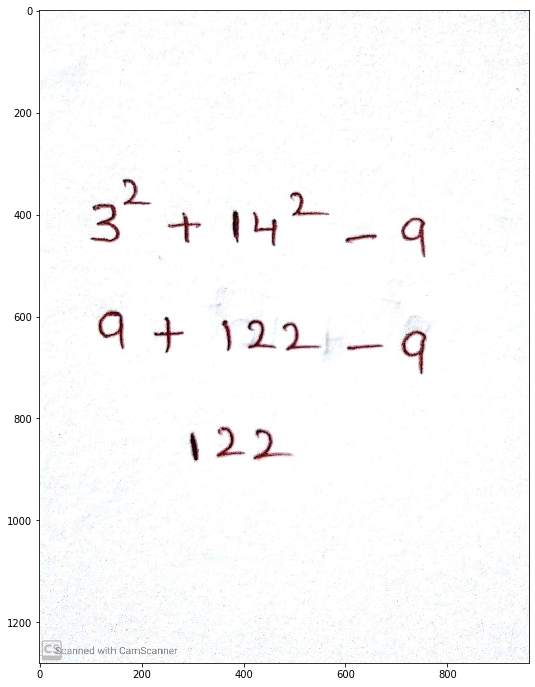

In [27]:
image_path = "mnp2.jpeg"
A = 2
B = 2
X = 98
Y = 3

img = cv2.imread(image_path)
plt.figure(figsize=(12,12))
plt.imshow(img)

In [28]:
def extract_line(image, beta=0.7, alpha=0.002):
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.02 * H)
    w5 = int(.02 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU) 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    temp = dilation.copy()
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE )
    areas = []
    for c in contours:
        areas.append([cv2.contourArea(c)**2])  
    cont_thresh= alpha * max(areas)[0]
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 10)
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    diff_1 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_1 = np.array([True if j > beta*(np.mean(diff_1)-np.std(diff_1)) else False for j in diff_1 ])
    uppers = uppers[diff_index_1]
    lowers = lowers[diff_index_1]
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff_1[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff_1[:-1])]
    diff_2 = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index_2 = np.array([True]*len(uppers))
    for i,diff in enumerate(diff_2):
        if(i>0):
            if( (diff_2[i-1] < (diff/2)) and (( lowers[i-1]-uppers[i]) > ((lowers[i-1]-uppers[i-1])/5)) ):
                uppers[i] = uppers[i-1]
                diff_2[i] = diff_2[i]+diff_2[i-1]
                diff_index_2[i-1] = False
    diff_index = diff_index_2
    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)

    return cleaned_orig, uppers[diff_index], lowers[diff_index]

In [29]:
def text_segment(Y1,Y2,X1,X2,box_num,line_name, dict_clean = dict_clean_img,\
                 acc_thresh = 0.60, show = True):
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    L_H = Y2-Y1   
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    erosion = cv2.erode(dilation,kernel,iterations = 1)
    
    # Find the contours
    if(cv2.__version__ == '3.3.1'):
        xyz,contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    else:
        contours,hierarchy = cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    areas = []
    for c in contours:
        areas.append([cv2.contourArea(c)**2])  
    ct_th = 0.005 * max(areas)[0]
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
                x1,y1,w1,h1 = bounding_boxes[i+1]
                if abs(x-x1) < 10 and  (h1+h) < 70:
                    #print(h+h1)
                    minX = min(x,x1)
                    minY = min(y,y1)
                    maxX = max(x+w, x1+w1)
                    maxY = max(y+h, y1+h1)
                    x,y,x11,y11 = minX, minY, maxX, maxY
                    
                    x,y,w,h = x,y,x11-x,y11-y
                    i = i+2
                    continue    
            if(h<0.10*L_H and w<0.10*L_H):
                i=i+1
                continue
            char_locs.append([x-2,y+Y1-2,x+w+1,y+h+Y1+1,w*h])
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)
            if i!=0:
                if y+h < (L_H*(1/2)) and y < bounding_boxes[i-1][1] and h < bounding_boxes[i-1][3]:
                    exp = 1
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            i = i+1
            char_type.append(exp)

    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['pred'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char['pred_proba'] = df_char.apply(lambda c: predict(dict_clean[box_num],c['X1'],\
           c['Y1'],c['X2'], c['Y2'], acc_thresh=acc_thresh), axis=1 )
    df_char.apply(lambda c: cv2.putText(img, c['pred'], (c['X1']-10,35), cv2.FONT_HERSHEY_SIMPLEX,  
                   1.5,(147,96,247), 3, cv2.LINE_AA), axis=1) 
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num
    return [box_num,line_name,df_char]

In [30]:
def sort_contours(cnts, method="left-to-right"):
    
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [31]:
def predict(img,x1,y1,x2,y2, acc_thresh = 0.60):
    gray = img[y1:y2, x1:x2]
    temp = gray.copy()
    kernel_temp = np.ones((3,3), np.uint8) 
    temp_tmp = cv2.dilate(temp, kernel_temp, iterations=3)
    contours_tmp,hierarchy = cv2.findContours(temp_tmp,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    if(len(contours_tmp) > 1):
        contours,hierarchy = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
        mask = np.ones(gray.shape[:2], dtype="uint8") * 0
        areas = [cv2.contourArea(c) for c in contours]
        max_index = np.argmax(areas)
        cnt=contours[max_index]
        cv2.drawContours(mask, [cnt], -1, 255, -1)
        gray = cv2.bitwise_and(temp, temp, mask=mask)
        
    grayN = process_img (gray, resize_flag = 0)
    
    classes = model.predict(grayN, batch_size=2)
    ind = np.argmax(classes)
    c = ['0','1','2','3','4','5','6','7','8','9','+','-','*','(',')']    
    return c[ind]

In [32]:
def process_img (gray, resize_flag = 1, preproc = 0):
    gray = gray.copy()
    if (preproc == 0):
        gray = cv2.GaussianBlur(gray,(7,7),0)
    else :
        kernel = np.ones((3,3), np.uint8)
        gray = cv2.dilate(gray, kernel, iterations=1)    
        gray = cv2.GaussianBlur(gray,(5,5),1)
        gray = cv2.dilate(gray, kernel, iterations=2)
        gray = cv2.erode(gray, kernel,iterations=2) 
    while np.sum(gray[0]) == 0:
        gray = gray[1:]

    while np.sum(gray[:,0]) == 0:
        gray = np.delete(gray,0,1)

    while np.sum(gray[-1]) == 0:
        gray = gray[:-1]

    while np.sum(gray[:,-1]) == 0:
        gray = np.delete(gray,-1,1)

    rows,cols = gray.shape
    
    if(resize_flag) == 1:
        interpolation=cv2.INTER_AREA
    else:
        interpolation=cv2.INTER_CUBIC
    if rows > cols:
        factor = 20.0/rows
        rows = 20
        cols = int(round(cols*factor))
        gray = cv2.resize(gray, (cols,rows),interpolation=interpolation)
    else:
        factor = 20.0/cols
        cols = 20
        rows = int(round(rows*factor))
        gray = cv2.resize(gray, (cols, rows),interpolation=interpolation)
    colsPadding = (int(math.ceil((28-cols)/2.0)),int(math.floor((28-cols)/2.0)))
    rowsPadding = (int(math.ceil((28-rows)/2.0)),int(math.floor((28-rows)/2.0)))
    gray = np.lib.pad(gray,(rowsPadding,colsPadding),'constant')
    shiftx,shifty = getBestShift(gray)
    shifted = shift(gray,shiftx,shifty)
    grayS = shifted
    grayS = grayS.reshape(1,1,28,28)
    grayS = grayS/255
    
    return grayS

In [33]:
def getBestShift(img):
    cy,cx = ndimage.measurements.center_of_mass(img)
    rows,cols = img.shape
    shiftx = np.round(cols/2.0-cx).astype(int)
    shifty = np.round(rows/2.0-cy).astype(int)

    return shiftx,shifty

In [34]:
def shift(img,sx,sy):
    rows,cols = img.shape
    M = np.float32([[1,0,sx],[0,1,sy]])
    shifted = cv2.warpAffine(img,M,(cols,rows))
    return shifted
train_datagen = ImageDataGenerator(   
    data_format='channels_first',
    zca_whitening = True,
    rotation_range = 0.2)

In [35]:
def evaluate(df,A,B,X,Y):
    '''Function to evaluate mathematical equation and give bool output
    Input: Dataframe
           Values
    Output:
        Boolean T/F
    '''
    #Evaluating Expression
    actual = A*X*X+(B*Y)

    pred = df["exp"].apply(lambda d: "**" if d==1 else "")
    pred = "".join(list(pred+df["pred"]))
        
 
    matchesN = re.findall('^\-\-', pred)
    if(len(matchesN) > 0):
        for s in matchesN:
             pred = pred.replace(s,'')       
                
            
        #looking for broken 5's
    matches5 = re.findall(r'5\*\*-\D*', pred)
    if(len(matches5) > 0):
        for s in matches5:
            sn = s.split('5**-')
            snew = sn[0]+'5'+sn[1]
            pred = pred.replace(s,snew)  

        

    matchesB_left = re.findall(r'\d\(\d', pred)
    matchesB_right = re.findall(r'\d\)\d', pred)
        
    if(len(matchesB_left) > 0 or len(matchesB_right) > 0):
        for s in matchesB_left:
            sn = s.split('(')
            snew = sn[0]+'*('+sn[1]
            pred = pred.replace(s,snew)    
                
        for s in matchesB_right:
            sn = s.split(')')
            snew = sn[0]+')*'+sn[1]
            pred = pred.replace(s,snew)
        
    a.append(pred)

In [36]:
df_lines = pd.DataFrame()
r=1
box = img
H,W = box.shape[:2]
cleaned_orig,y1s,y2s = extract_line(box)
x1s = [0]*len(y1s)
x2s = [W]*len(y1s)    
df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
df.columns = ['y1','y2','x1','x2']
df['box_num'] = r

df_lines= pd.concat([df_lines, df])

dict_clean_img.update({r:cleaned_orig})
dict_img.update({r:box})
df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]

In [37]:
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],\
                 row['x1'],row['x2'], row['box_num'],row['line_name']), axis=1))

In [38]:
tfback._get_available_gpus = _get_available_gpus
tfback._get_available_gpus()

[]

In [39]:
a=[]

In [40]:
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']
    
box_nums = df_chars.box_num.unique()
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )
gamma = 0
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

for bn in box_nums:
    box_img = dict_clean_img[bn] 
    box_img_1 = dict_img[bn] 
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn].copy()
    
    df_l = df_lines[df_lines["box_num"]==bn].copy() 
    
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, \
      (c['X1'],c['Y1']),(c['X2'], c['Y2']),(255*(c['exp']==1),180,0),2+(2*c['exp'])), axis=1 ) )
    
    df['line_status'] = df['char_df'].apply(lambda d: evaluate(d[["pred","exp","pred_proba"]],A,B,X,Y))
    
    scale_percent = 200 


In [41]:
a

['3**2+14**2-9', '9+122-9', '122']

In [42]:
b=[]

In [43]:
for i in a:
    b.append(eval(i))

In [44]:
b

[196, 122, 122]

In [45]:
for i in range(1,len(b)):
    if b[0] == b[i]:
        print("correct")
    else:
        print("wrong")

wrong
wrong
